# Урок 6. Практическое задание

1. Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров. 
2. Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [38]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [29]:
from sklearn.datasets import load_diabetes

In [30]:
X, y = load_diabetes(return_X_y=True)

In [31]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [32]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже считаются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [33]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем  𝐿2
L
2
  loss  𝐿(𝑦,𝑧)=(𝑦−𝑧)2,
L
(
y
,
z
)
=
(
y
−
z
)
2
,
  её производная по  𝑧
z
  примет вид  𝐿′(𝑦,𝑧)=2(𝑧−𝑦)
L
′
(
y
,
z
)
=
2
(
z
−
y
)
 . Реализуем её также в виде функции — коэффициент 2 можно отбросить.

In [34]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [35]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [9]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}\n')

In [11]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1000.70186963786
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 5334.580087935745



Построим графики зависимости ошибки на обучающей и тестовой выборках от числа деревьев в ансамбле.

In [12]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

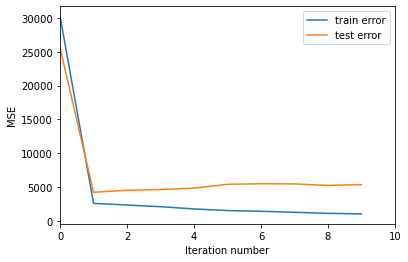

In [13]:
get_error_plot(n_trees, train_errors, test_errors)

Построим графики зависимости ошибки на обучающей и тестовой выборках от максимальной глубины деревьев.

In [14]:
train_errors = []
test_errors = []
n_trees = 10
coefs = [1] * n_trees
eta = 0.1

for max_depth in range(1, 21):
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 1     с шагом 0.1 на тренировочной выборке: 6851.154085835889
Ошибка алгоритма из 10 деревьев глубиной 1     с шагом 0.1 на тестовой выборке: 5460.564732565487

Ошибка алгоритма из 10 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 6141.745368862066
Ошибка алгоритма из 10 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 5233.661092303652

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 5715.249881863428
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 5290.1445428243005

Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 5229.530881931765
Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 5324.801724529553

Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 4816.103776770944
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 5439.029

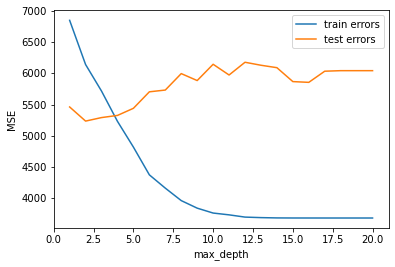

In [16]:
x = list(range(1, 21))

plt.xlim(0, 21)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right');

#### сделал так, потому что долго считает

In [23]:
train_errors = []
test_errors = []
coefs = [1] * n_trees
eta = 0.1
max_depth = 5
n_trees_set = [1, 3, 5, 10, 20, 30, 40, 50, 100, 150]
for i in n_trees_set:  
    n_trees=i
    #print (f'n_trees: {n_trees}')
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 1 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 24836.92199441983
Ошибка алгоритма из 1 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 21083.37993037978

Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 16875.307539566802
Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 14780.583105507625

Ошибка алгоритма из 5 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 11563.615213316478
Ошибка алгоритма из 5 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 10481.27104761966

Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 4816.103776770944
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 5439.0295010238615

Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 1272.7183453999128
Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3702.16056

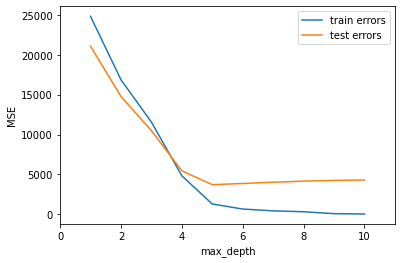

In [25]:
x = list(range(1, 11))

plt.xlim(0, 11)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right');

#### 2. Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [86]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

In [87]:
from sklearn.datasets import load_diabetes

In [88]:
X, y = load_diabetes(return_X_y=True)

In [89]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [90]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже считаются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [91]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [92]:
def bias(y, z):
    return (y - z)

In [115]:
def stc_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, sample_size = 0.5):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            get_choice = list(range(X_train.shape[0]))
            train_index = np.random.choice(get_choice, size=int(0.5*len(get_choice)))
            # Получим ответы на текущей композиции
            target = gb_predict(X_train[train_index], trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[train_index], bias(y_train[train_index], target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [129]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees, train_errors_stc, test_errors_stc = stc_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [130]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [131]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 5703.0296803980955
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 6229.309615925379


In [132]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [135]:
def get_error_plot(n_trees, test_err, test_errors_stc):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), test_errors, label='boost')
    plt.plot(list(range(n_trees)), test_errors_stc, label='stohastic boost')
    plt.legend(loc='upper right')
    plt.show()


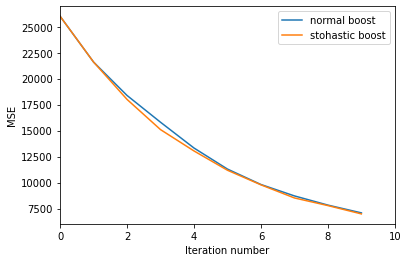

In [136]:
get_error_plot(n_trees, test_errors, test_errors_stc)